Coupling map:


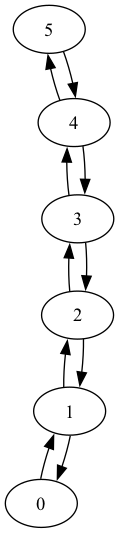

In [2]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt
from rl_qoc.helpers.transpiler_passes import CausalConePass

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

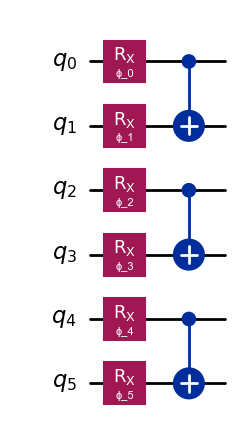

In [3]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


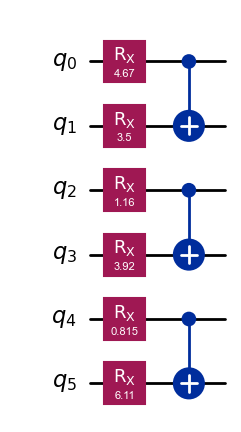

In [4]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

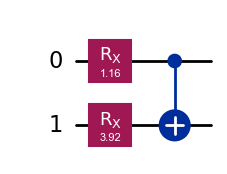

In [5]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

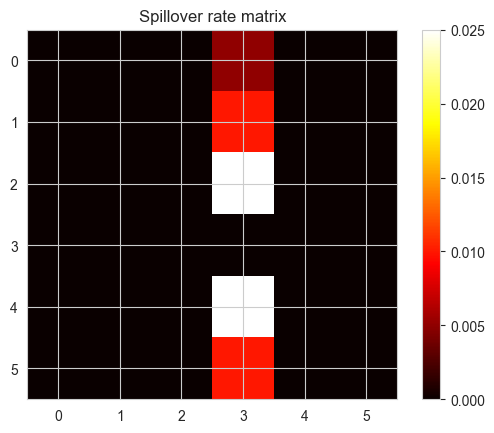

In [6]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.005  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[1, 3] = 0.01  # γ_1->3
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.025  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 3] = 0.01  # γ_5->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)

# Generate another gamma matrix based on coupling map defined above
# gamma_matrix = 0.0 * np.eye(num_qubits)
# for edge in cm.get_edges():
#     gamma_matrix[edge[0], edge[1]] = 0.05


# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [7]:
gamma_matrix

array([[0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.025, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.01 , 0.   , 0.   ]])

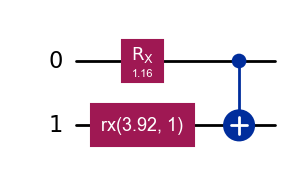

In [8]:
spillover_pass = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
causal_cone_pass = CausalConePass((2, 3))
pm = PassManager([spillover_pass, causal_cone_pass])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = circuit.assign_parameters(param_dict)
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [9]:
qc_noisy.qubits

[Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)]

In [10]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1607433119572852]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [11]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [12]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '2db15852a9344b96a5f2758cb42f01ec',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [13]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager(
    [spillover_pass, causal_cone_pass] + full_pm.translation._tasks[0]
)
full_pm.translation = custom_translation_pass

In [14]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x35aeb6890>,

In [15]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [16]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '2db15852a9344b96a5f2758cb42f01ec',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99644118+0.j        , 0.        -0.08429101j],
              [0.        -0.08429101j, 0.99644118+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [17]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


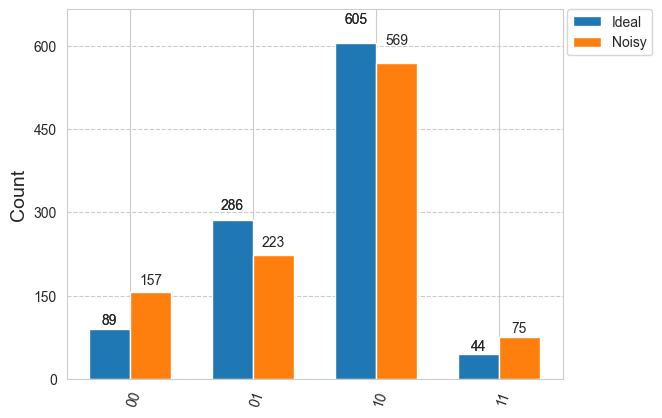

In [18]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [19]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [20]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9943160204742245

In [21]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


# def apply_parametrized_circuit(
#     qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
# ):
#     """
#     Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
#     This function is used to run the QuantumCircuit instance on a Runtime backend
#     :param qc: Quantum Circuit instance to add the gate on
#     :param params: Parameters of the custom Gate
#     :param q_reg: Quantum Register formed of target qubits
#     :return:
#     """
#     target = kwargs["target"]
#     my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
#     optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
#     # optimal_params = np.pi * np.zeros(len(params))
#     new_params = [optimal_params[i] + params[i] for i in range(len(params))]

#     my_qc.u(
#         new_params[0],
#         -np.pi/2,
#         np.pi/2,
#         q_reg[0],
#     )
#     my_qc.u(
#         0.,
#         new_params[1],
#         new_params[2],
#         q_reg[0],
#     )
#     my_qc.u(
#         *new_params[3:6],
#         q_reg[1],
#     )

#     my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

#     qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [22]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.20, high=0.20, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[10,],
        n_shots=100,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)

In [23]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit


class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        self.discrete_reward_history = np.ones(
            (discrete_history_length, self.num_params)
        )
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        self.discrete_obs_vals_raw = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ) #.flatten()
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")
        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.prob_weights = np.ones_like(self.single_qubit_discrete_obs_vals_raw)
        self.prob_weights /= len(self.prob_weights)

        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2

        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2

        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale

        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        if self.circuit_param_distribution == "simple_discrete":
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
            print(obs_raw)
        if self.circuit_param_distribution == "moving_discrete":
            ### Only works for single qubit spillover ###
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0], # Will hit error if used for more than single qubit
                replace=True,
                p=self.prob_weights,
            )
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")

        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals_raw - obs))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_raw  # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}


In [24]:
import numpy as np
from typing import Optional, Dict, Any, SupportsFloat
from qiskit import QuantumCircuit
from rl_qoc.environment.context_aware_quantum_environment import (
    ObsType,
    ActType,
    ContextAwareQuantumEnvironment,
)
from gymnasium.spaces import Box
from rl_qoc import ContextAwareQuantumEnvironment, QEnvConfig, GateTarget
from spillover_effect_on_subsystem import (
    noisy_backend,
    circuit_context,
    LocalSpilloverNoiseAerPass,
    numpy_to_hashable,
)
from rl_qoc.helpers import causal_cone_circuit
import itertools

class GeneralAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params: int,
        discrete_history_length: int,
        applied_qubits: list,  # list of qubits which we will include the effect of
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
        obs_bounds: Optional[tuple] = (-np.pi, np.pi),
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters
        self.num_qubits = len(applied_qubits)  # Number of qubits

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-1.0] * len(applied_qubits)),
            high=np.array([1.0] * len(applied_qubits)),
            dtype=np.float64,
        )
        self.obs_bounds = obs_bounds

        # Define discrete observation values for a single qubit
        self.single_qubit_discrete_obs_vals_raw = np.linspace(
            self.observation_space.low[0], self.observation_space.high[0], self.num_params
        )
        # Generate all possible combinations for N qubits
        self.discrete_obs_vals_raw = np.array(
            list(itertools.product(self.single_qubit_discrete_obs_vals_raw, repeat=self.num_qubits))
        )
        self.discrete_obs_vals_angles = self.obs_raw_to_angles(self.discrete_obs_vals_raw)
        print(f"Observation Vals for Agent: {self.discrete_obs_vals_raw}")
        print(f"Observation Vals for Env: {self.discrete_obs_vals_angles}")

        # Initialize reward history and probability weights for all possible combinations
        self.discrete_reward_history = np.ones(
            (discrete_history_length, len(self.discrete_obs_vals_raw))
        )
        self.prob_weights = np.ones(len(self.discrete_obs_vals_raw))
        self.prob_weights /= len(self.prob_weights)

        self.obs_angles = np.zeros(self.observation_space.shape)
        self.applied_qubits = applied_qubits
        self.obs_raw = np.zeros(self.observation_space.shape)

    def obs_raw_to_angles(self, obs_raw):
        # Obs raw between -1. and 1.
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = obs_raw * scale
        angles = obs_scaled + mean
        return angles

    def angles_to_obs_raw(self, angles):
        # Angles between self.obs_bounds[0] and self.obs_bounds[1]
        # Obs raw between -1. and 1.
        scale = (self.obs_bounds[1] - self.obs_bounds[0]) / 2
        mean = (self.obs_bounds[0] + self.obs_bounds[1]) / 2
        obs_scaled = angles - mean
        obs_raw = obs_scaled / scale
        return obs_raw

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        """
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
            self.obs_raw = self.angles_to_obs_raw(self.obs_angles)
        else:
            self.obs_raw = self._get_new_obs_raw()
            self.obs_angles = self.obs_raw_to_angles(self.obs_raw)

        self.phi_vec = np.zeros(self.unbound_circuit_context.num_qubits)
        self.phi_vec[self.applied_qubits] = self.obs_angles

        param_dict = {self.circuit_parameters[i].name: self.phi_vec[i] for i in range(len(self.phi_vec))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", self.phi_vec)
        print(f"Environment Observation: {env_obs}")
        return env_obs, {}

    def _get_new_obs_raw(self):
        if self.circuit_param_distribution == "uniform":
            obs_raw = np.random.uniform(
                self.observation_space.low,
                self.observation_space.high,
                self.observation_space.shape,
            )
        elif self.circuit_param_distribution == "simple_discrete":
            # Sample each qubit's observation independently
            obs_raw = np.random.choice(
                a=self.single_qubit_discrete_obs_vals_raw,
                size=self.observation_space.shape[0],
                replace=True,
            )
        elif self.circuit_param_distribution == "moving_discrete":
            # Update probability weights based on reward history
            self.prob_weights = (
                np.mean(self.discrete_reward_history, axis=0)
                + np.log10(self.optimal_error_precision)
            ) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            # Sample an index from all possible combinations
            idx = np.random.choice(
                len(self.discrete_obs_vals_raw),
                p=self.prob_weights,
            )
            obs_raw = self.discrete_obs_vals_raw[idx]
        return obs_raw

    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:
        print(f"batch action shape: {action.shape}")
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        if self.circuit_param_distribution == "moving_discrete":
            self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info

    def update_discrete_history(self, reward, obs):
        # Find the index of the closest discrete observation value
        obs_ind = np.argmin(np.sum((self.discrete_obs_vals_raw - obs) ** 2, axis=1))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )

    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        """
        return self.obs_raw

    def _get_info(self) -> Any:
        return {}

In [25]:
# Constructing general angle spillover env

# from general_angle_spillover_env import GeneralAngleSpilloverEnv

general_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2,],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]
Observation Vals for Env: [[0.        ]
 [0.78539816]
 [1.57079633]
 [2.35619449]
 [3.14159265]]


In [26]:
print(general_env.discrete_obs_vals_raw)

[[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]


In [27]:
rescaled_general_env = RescaleAndClipAction(general_env, min_action=-1., max_action=1.)

In [28]:
_, _ = general_env.reset(
    debug_obs=np.array([np.pi,])
)

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]


In [29]:
print(general_env.observation_space.shape[0])

1


In [30]:
print(gamma_matrix.T)

[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.005 0.01  0.025 0.    0.025 0.01 ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]]


In [31]:
computed_spillover_angles = general_env.gamma_matrix.T @ general_env.phi_vec
subsystem_spillover_angles = computed_spillover_angles[[2,]]
subsystem_spillover_angles / np.pi

opt_action = np.zeros((1, 7))
opt_action[0, [2,]] = -subsystem_spillover_angles

In [32]:
opt_action

array([[ 0.,  0., -0.,  0.,  0.,  0.,  0.]])

Number of repetitions: 1
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512
Reward (avg): 0.9987669334932512 Std: 0.0
Number of repetitions: 3
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512
Reward (avg): 0.9889479681590705 Std: 0.0
Number of repetitions: 5
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512
Reward (avg): 0.9695518130045148 Std: 0.0
Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512
Reward (avg): 0.941056065741637 Std: 0.0
Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9987669334932512
Reward (avg): 0.9041623862400128 Std: 0.0
Number of repetitions: 11
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (

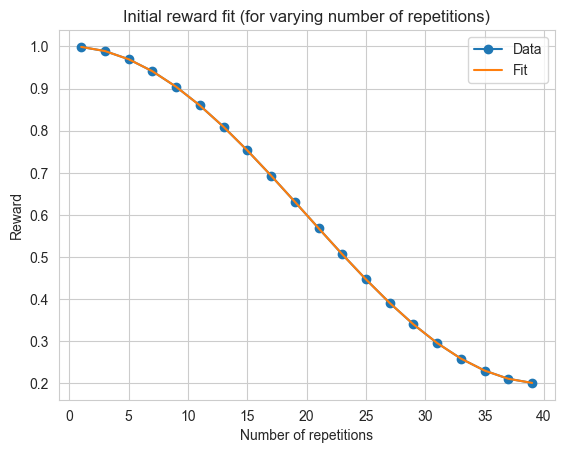

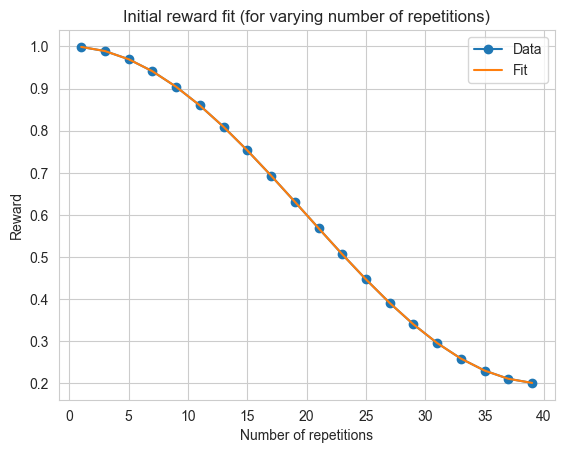

In [33]:
general_env.initial_reward_fit(
    np.zeros((1, 7)),
    # opt_action,
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 40, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method="fidelity",
    # fit_p0=list(subsystem_spillover_angles)
)

## Running Training for One Spillover Qubit, Fidelity Access, with Random Uniform Sampling

In [34]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2,],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals for Agent: [[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]
Observation Vals for Env: [[0.        ]
 [0.78539816]
 [1.57079633]
 [2.35619449]
 [3.14159265]]


In [35]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1749360149/Test PPO CleanRL.cleanrl_model


Text(0.5, 0, 'Policy update')

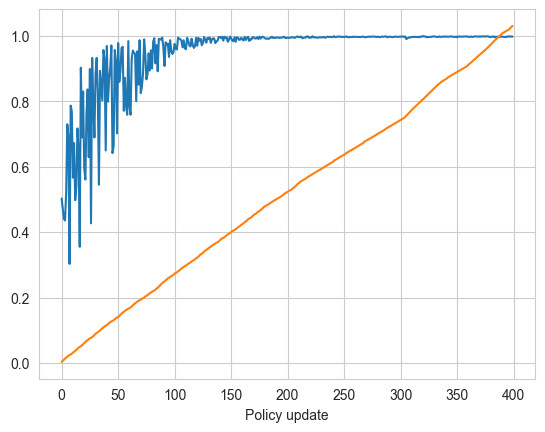

In [50]:
plt.plot(np.mean(rescaled_q_env.unwrapped.reward_history, axis=-1), label="Reward")
plt.plot(np.cumsum(rescaled_q_env.unwrapped.total_shots)/1e8, label='Total number of shots (x 1e8)')
plt.xlabel("Policy update")
plt.ylabel("Reward")
plt.ylabel("Shot budget (x 100 Million)")

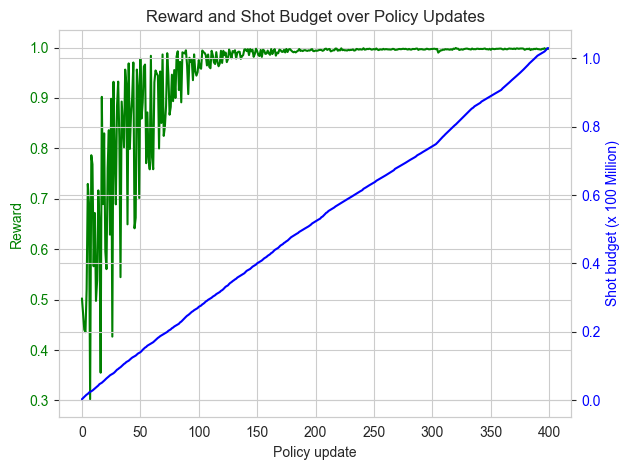

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming rescaled_q_env is defined and has the necessary attributes
# rescaled_q_env.unwrapped.reward_history and rescaled_q_env.unwrapped.total_shots

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the reward history on the first y-axis
reward_mean = np.mean(rescaled_q_env.unwrapped.reward_history, axis=-1)
ax1.plot(reward_mean, 'g-', label="Reward")
ax1.set_xlabel("Policy update")
ax1.set_ylabel("Reward", color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Create a second y-axis with the same x-axis
ax2 = ax1.twinx()

# Plot the total number of shots on the second y-axis
total_shots_cumsum = np.cumsum(rescaled_q_env.unwrapped.total_shots) / 1e8
ax2.plot(total_shots_cumsum, 'b-', label='Total number of shots (x 1e8)')
ax2.set_ylabel("Shot budget (x 100 Million)", color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Show the plot
plt.title('Reward and Shot Budget over Policy Updates')
fig.tight_layout()
plt.show()

## Evaluating Learned Policy from Random Discrete Context Sampling

In [35]:
NUM_EVAL = 25
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369
Reward (avg): 0.998108955821836 Std: 0.0042504789155175015
obs: [0.5]
reward: [2.23003281 2.31055525 2.314566   2.70768956 2.09765113 3.05183043
 6.         2.2914503  6.         6.         2.22157972 2.26740455
 6.         2.84622669 6.         6.         2.53771173 6.
 3.18299544 6.         2.63168463 2.5377158  6.         6.
 2.34857189 1.87724755 2.40412933 1.97094274 6.         6.
 6.         2.67992809]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9996847356939461 Std: 0.004785060473656594
obs: [0.5]
reward: [2.64291724 6.         2.72559994 6.         6.         3.11096429
 2.74968934 2.92189235 6.         6.         6.         6.
 2.75069638 6.         2.39788638 6.         6.         2.09831829
 2.37375669 2.60352948 6.         6.         6.         6.
 2.20133859 2.35611836 2.5611962  6.         2.32224247 2.07503381
 3.50673926 2.08484368]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0008950568934107 Std: 0.0052425492621714
obs: [0.5]
reward: [1.92555939 6.         2.6047876  6.         4.23793198 6.
 6.         6.         6.         6.         6.         2.45273145
 6.         6.         6.         6.         2.3592371  2.61942783
 6.         6.         3.0259718  6.         6.         6.
 6.         3.02051591 1.97579087 2.67702303 2.07433357 2.44453915
 3.36257774 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9977196356008369 Std: 0.004886738408166224
obs: [0.5]
reward: [2.81711683 6.         2.3182339  2.73126778 3.21919335 2.78787144
 2.6020151  2.07574916 2.09040908 6.         6.         3.45861932
 2.00287336 6.         6.         6.         2.1664107  6.
 6.         6.         2.64986999 2.38663904 2.50472759 2.90348292
 6.         2.3308797  6.         2.02517412 2.55344083 2.45533643
 1.7802622  2.06519154]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9992312018946838 Std: 0.0043602738206432
obs: [0.5]
reward: [6.         6.         2.35003293 6.         6.         2.10825765
 2.12366277 3.98434803 6.         6.         2.64983618 2.312834
 6.         2.27391481 4.7325458  6.         2.08151585 2.42046818
 2.94287495 6.         6.         2.2068581  2.15777441 6.
 2.72623346 6.         2.61627806 6.         2.42243362 3.57282451
 2.48947646 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9995042332285463 Std: 0.005399342280035335
obs: [0.5]
reward: [6.         2.45922136 2.86666042 2.82231023 2.73330349 2.61719507
 6.         2.04078323 2.12903201 6.         6.         2.01091841
 2.79845287 2.38544462 2.37146798 2.75728148 2.93346924 6.
 6.         6.         2.07776311 2.22809386 6.         2.81217865
 2.93540136 2.36996788 6.         6.         2.37626089 2.32838613
 6.         6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9997610427190682 Std: 0.003859149929066522
obs: [0.5]
reward: [2.51062042 6.         2.02752009 2.8456081  6.         6.
 3.3862612  3.70600676 2.27384922 2.41512917 2.68122981 6.
 6.         6.         2.02567541 2.67679634 6.         6.
 2.38200714 3.09431019 6.         6.         6.         6.
 6.         2.80396253 3.06550647 6.         2.56071983 6.
 6.         2.3168129 ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9987682602394586 Std: 0.004807582487710216
obs: [0.5]
reward: [2.0705674  3.02024937 2.5924123  2.16741101 2.01400781 2.26612482
 6.         3.67076119 2.72865988 6.         6.         2.18476593
 6.         6.         6.         6.         2.5435964  6.
 2.66647249 2.55656076 2.28808914 2.89134209 1.96870228 2.38245234
 2.57665848 3.5148997  6.         3.45044195 2.23272811 6.
 3.51499078 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9987410173255635 Std: 0.004787627181252741
obs: [0.5]
reward: [2.27279214 3.15963275 6.         6.         6.         6.
 6.         2.39142014 6.         2.47166688 6.         6.
 6.         2.41517971 2.34927874 6.         2.56680589 2.41310839
 2.30829711 6.         2.88327521 2.1072649  2.32452497 3.08149752
 2.08108221 2.61752643 2.18292371 1.82320643 6.         6.
 3.94513699 2.41003564]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369
Reward (avg): 1.0003995744340615 Std: 0.004215120074200691
obs: [0.5]
reward: [4.39804033 6.         2.30339692 6.         2.32936117 3.50985605
 6.         6.         2.62074549 2.09398528 6.         6.
 2.93927275 6.         6.         1.92514605 6.         2.67570151
 2.64918122 6.         6.         6.         6.         6.
 6.         6.         6.         2.36255196 3.5919235  6.
 6.         2.76093136]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9990033085688741 Std: 0.004805969187987016
obs: [0.5]
reward: [6.         2.40844666 6.         6.         2.48246291 2.87496779
 2.1148593  2.25641172 6.         6.         6.         2.10506585
 2.37420396 6.         2.43418411 3.6374552  2.22052189 2.31765888
 6.         2.55362123 2.18277276 6.         6.         2.57913099
 6.         2.26846246 6.         2.13026073 2.13557423 6.
 2.58681574 3.24342499]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9986308210714228 Std: 0.005655760925423287
obs: [0.5]
reward: [2.80657592 2.66510049 2.18297183 6.         6.         2.87487594
 6.         2.45044988 2.15838505 2.43764519 6.         6.
 2.42745264 2.25814451 2.47506937 6.         2.21942011 2.42016639
 6.         2.20879329 2.34098476 6.         2.13379323 2.05945079
 6.         2.72655838 2.72308463 6.         6.         2.464667
 1.98702144 2.22640677]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9996861666738683 Std: 0.003121029052913602
obs: [0.5]
reward: [2.70517792 3.48645901 2.93119817 3.23330573 6.         6.
 2.55445674 6.         2.89317985 6.         2.51637239 2.82445421
 6.         6.         2.89408579 6.         2.55119962 2.36118995
 6.         6.         3.05360131 4.61484936 3.15015581 6.
 6.         2.41638743 3.14463211 3.04256593 2.41501679 2.56883808
 2.17746117 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9991220984640792 Std: 0.005644334157338728
obs: [0.5]
reward: [2.10807251 6.         2.29745819 2.658518   6.         6.
 6.         2.0571585  2.11425501 2.62176697 2.50612652 2.57815156
 2.21360319 2.53636014 2.2635766  2.36591652 1.94311418 2.83807534
 6.         6.         6.         6.         3.29517573 2.50956273
 2.37954376 6.         6.         6.         6.         2.10382916
 6.         2.59618014]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9977889776888339 Std: 0.004019491033713453
obs: [0.5]
reward: [6.         1.98821961 2.89510908 6.         6.         3.20576602
 3.00595762 2.37459246 3.16357809 2.35221638 6.         6.
 2.32431339 2.44204223 6.         6.         1.98075946 2.95431623
 2.06409564 6.         2.9442251  2.86961637 2.58088094 1.99238899
 2.76799309 3.46902832 2.01673832 6.         2.8772434  6.
 2.44527481 2.24878557]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.997725399948602 Std: 0.004357678679280207
obs: [0.5]
reward: [6.         6.         6.         2.46128401 2.20262491 2.18577628
 6.         2.06429845 6.         6.         6.         2.2675204
 2.20149067 2.74980828 1.83149597 2.57773119 6.         6.
 2.24940754 2.44876427 2.54974299 6.         6.         6.
 2.04453479 2.16741707 2.5324808  2.38558904 2.88035511 6.
 2.5872409  2.48565119]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9994122894141323 Std: 0.005732531938649774
obs: [0.5]
reward: [6.         2.09654049 1.95572385 2.31991233 2.71434809 2.20654179
 2.2054566  2.06180356 6.         2.59460964 2.73440824 6.
 3.23424644 6.         1.94631189 6.         6.         6.
 6.         6.         6.         2.35492891 6.         6.
 6.         2.49914375 6.         2.04500966 2.19145961 2.77364606
 6.         6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.000057926237523 Std: 0.003910509152572364
obs: [0.5]
reward: [2.66775846 6.         6.         6.         2.16840935 2.67807998
 6.         6.         2.24001299 6.         2.30380516 2.78267467
 6.         6.         2.10244803 2.43846739 6.         2.62676019
 6.         6.         6.         6.         2.67343114 2.58995663
 6.         6.         6.         6.         2.61002338 6.
 2.50534661 2.30848843]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.000317511551773 Std: 0.004460859342992453
obs: [0.5]
reward: [6.         3.41806026 6.         6.         6.         2.76903437
 2.24520438 3.07050255 6.         6.         6.         2.52649012
 3.26613403 6.         6.         2.40173875 6.         2.40487936
 2.38929619 2.51432994 6.         6.         6.         3.96391135
 2.72220192 2.06401891 2.41109947 2.49147371 6.         6.
 2.2898443  2.23021364]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0015447230305832 Std: 0.006075985209271002
obs: [0.5]
reward: [3.56202224 6.         6.         6.         1.9313116  6.
 6.         6.         6.         6.         2.39761825 2.17493522
 2.71212832 6.         6.         2.21545762 6.         6.
 6.         2.66504772 6.         6.         2.45141901 2.42275792
 3.26925845 2.7530837  6.         2.681477   6.         6.
 1.84668316 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.99774696573129 Std: 0.004877974415329383
obs: [0.5]
reward: [2.19839639 2.35033125 2.05485125 6.         2.48543537 2.96328457
 6.         2.34312796 2.16485186 2.17939367 6.         2.30585428
 2.22892202 3.27822849 2.36478764 2.08845789 6.         6.
 2.25222382 1.99668839 6.         2.45992269 6.         2.43076383
 2.22274775 2.89006913 2.21415651 2.66032001 2.38637392 6.
 2.49391194 4.00075082]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9981256138994885 Std: 0.004126824105805025
obs: [0.5]
reward: [2.35881902 2.38810422 2.63310884 6.         2.78226132 2.51846714
 6.         2.35162056 2.12792461 6.         2.62680384 2.50016105
 6.         2.42225005 2.00202818 2.0432355  6.         6.
 6.         2.26191838 2.33529329 2.50380509 2.61236288 2.83357954
 6.         6.         2.93360076 2.64346833 2.07428697 6.
 2.31621418 2.62618929]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0007162692631506 Std: 0.004750735302196162
obs: [0.5]
reward: [2.885595   6.         2.3383854  6.         2.51834216 2.03413855
 2.18813895 2.33968722 2.8098891  6.         6.         6.
 3.1910357  6.         6.         6.         2.43193218 6.
 2.31852247 6.         6.         3.06969923 6.         6.
 6.         2.34238337 6.         3.86719809 6.         6.
 2.25138707 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9994017087971909 Std: 0.004593876834844321
obs: [0.5]
reward: [2.11651517 6.         2.13938084 2.6405679  2.66149702 6.
 2.04753193 2.27107191 6.         2.52514755 3.176196   3.69228763
 6.         2.66382752 6.         6.         2.63339037 2.24648988
 6.         2.43509922 6.         2.33397314 2.28403022 2.15360232
 6.         6.         2.47315159 6.         6.         6.
 2.99602802 6.        ]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity (per Cycle):  0.9993340674006369


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.000553652831476 Std: 0.003766965832672639
obs: [0.5]
reward: [2.14670729 6.         6.         6.         6.         6.
 2.2179807  6.         6.         6.         3.0722387  6.
 6.         2.20291958 6.         2.1422923  6.         2.43849203
 6.         2.81032512 6.         3.17417889 3.14510721 2.80930374
 6.         6.         6.         2.74097612 3.22392805 2.81845456
 6.         3.22809271]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_9735/1482633183.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


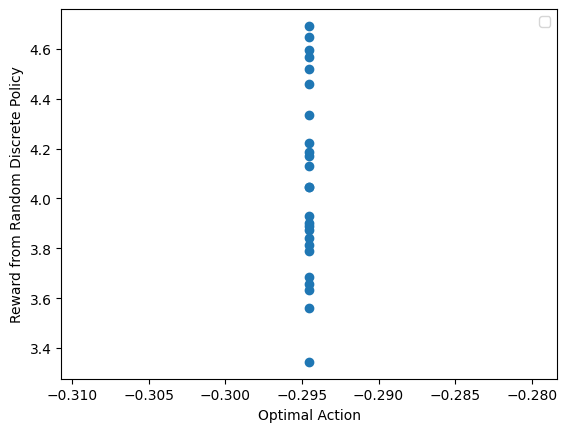

In [36]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2,], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.2

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

In [37]:
df_hist = ppo_agent.env.unwrapped.discrete_reward_history

print(df_hist.shape)

(3, 5)


In [38]:
print(df_hist)

[[3.89159634 3.59812959 3.69569603 4.56784366 4.0136687 ]
 [4.0855247  4.39590965 3.9874976  4.04655588 4.08392687]
 [3.99830512 4.01180172 4.30380886 4.51832295 3.92628168]]


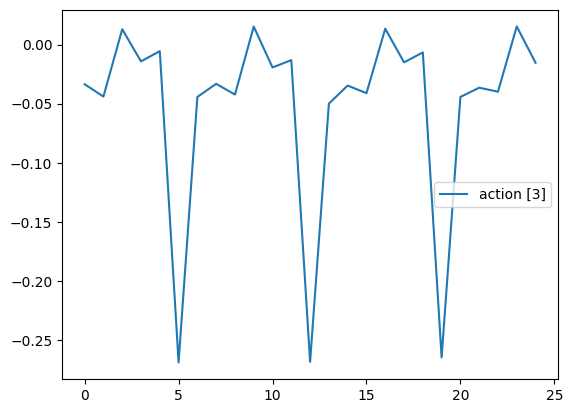

In [39]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

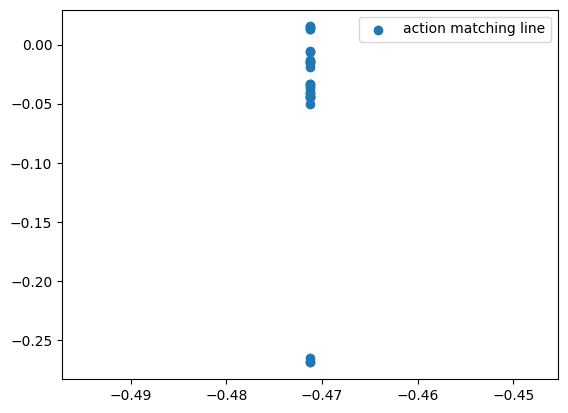

In [40]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1) / 0.25

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [41]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1.  -1. ]
 [-1.  -0.5]
 [-1.   0. ]
 [-1.   0.5]
 [-1.   1. ]
 [-0.5 -1. ]
 [-0.5 -0.5]
 [-0.5  0. ]
 [-0.5  0.5]
 [-0.5  1. ]
 [ 0.  -1. ]
 [ 0.  -0.5]
 [ 0.   0. ]
 [ 0.   0.5]
 [ 0.   1. ]
 [ 0.5 -1. ]
 [ 0.5 -0.5]
 [ 0.5  0. ]
 [ 0.5  0.5]
 [ 0.5  1. ]
 [ 1.  -1. ]
 [ 1.  -0.5]
 [ 1.   0. ]
 [ 1.   0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.         0.78539816]
 [0.         1.57079633]
 [0.         2.35619449]
 [0.         3.14159265]
 [0.78539816 0.        ]
 [0.78539816 0.78539816]
 [0.78539816 1.57079633]
 [0.78539816 2.35619449]
 [0.78539816 3.14159265]
 [1.57079633 0.        ]
 [1.57079633 0.78539816]
 [1.57079633 1.57079633]
 [1.57079633 2.35619449]
 [1.57079633 3.14159265]
 [2.35619449 0.        ]
 [2.35619449 0.78539816]
 [2.35619449 1.57079633]
 [2.35619449 2.35619449]
 [2.35619449 3.14159265]
 [3.14159265 0.        ]
 [3.14159265 0.78539816]
 [3.14159265 1.57079633]
 [3.14159265 2.35619449]
 [3.14159265 3.14159

In [42]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals_raw:
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [43]:
print(std_actions)

[array([0.00315028, 0.00281563, 0.00418258, 0.00191215, 0.00387006,
       0.00314626, 0.00257206], dtype=float32), array([0.00289373, 0.00216003, 0.0033381 , 0.00199705, 0.00335393,
       0.00326334, 0.00231343], dtype=float32), array([0.00311832, 0.00296816, 0.00408558, 0.002711  , 0.00402191,
       0.00297092, 0.00279053], dtype=float32), array([0.00321795, 0.00268215, 0.00301389, 0.00251567, 0.00435646,
       0.00301359, 0.00285057], dtype=float32), array([0.00303926, 0.00212386, 0.00337386, 0.00233072, 0.00431072,
       0.00250066, 0.00338108], dtype=float32)]


In [44]:
actions = np.array(actions)

o_vals = ppo_agent.env.unwrapped.discrete_obs_vals_angles
o_vals

array([[0.        ],
       [0.78539816],
       [1.57079633],
       [2.35619449],
       [3.14159265]])

In [45]:
ana_sum = -np.sum(o_vals, axis=1) * 0.02
ana_sum

array([-0.        , -0.01570796, -0.03141593, -0.04712389, -0.06283185])

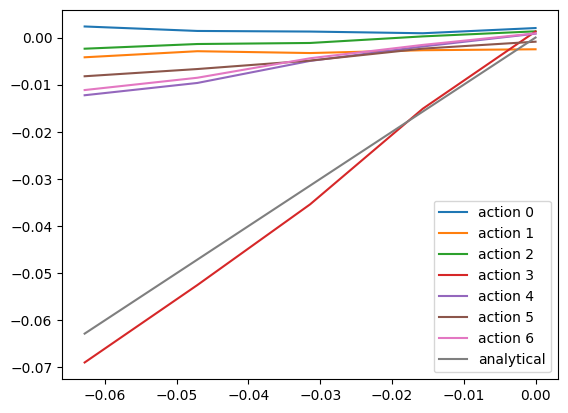

In [46]:
for i in range(len(actions[0])):
    plt.plot(ana_sum, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(ana_sum, ana_sum, label=f'analytical')
plt.legend()
plt.show()

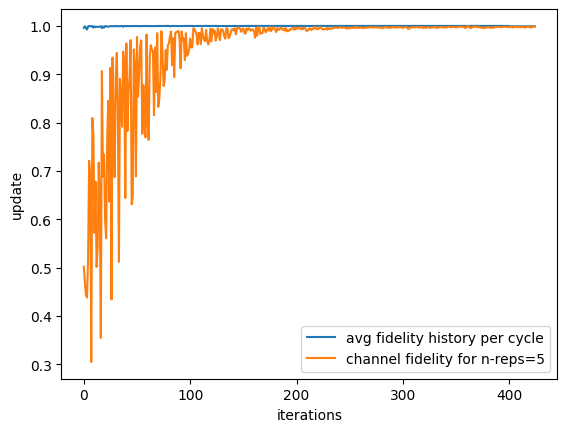

In [47]:
# Plot Average per-cycle Gate Fidelity during training

avg_fidelity_history = ppo_agent.env.unwrapped.fidelity_history
avg_fidelity_history_n_reps = ppo_agent.env.unwrapped.avg_fidelity_history_nreps
n_reps_channel_fidelity = np.mean(ppo_agent.env.unwrapped.reward_history, axis=-1)

plt.plot(avg_fidelity_history, label='avg fidelity history per cycle')
plt.plot(n_reps_channel_fidelity, label='channel fidelity for n-reps=5')
# plt.plot(avg_fidelity_history_n_reps, label='avg fidelity history n-reps')
# plt.axhline()
plt.xlabel('iterations')
plt.ylabel('update')
plt.legend()
plt.show()

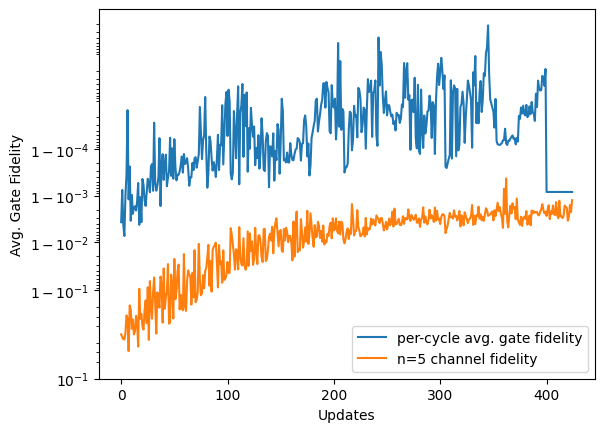

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are your data arrays
single_rep_reward_history = avg_fidelity_history
mean_reward_history = n_reps_channel_fidelity

# Replace any invalid values
single_rep_reward_history = np.nan_to_num(single_rep_reward_history, nan=0.0, posinf=1.0, neginf=0.0)
mean_reward_history = np.nan_to_num(mean_reward_history, nan=0.0, posinf=1.0, neginf=0.0)

plt.plot(single_rep_reward_history, label='per-cycle avg. gate fidelity')
plt.plot(mean_reward_history, label='n=5 channel fidelity')
plt.xlabel('Updates')
plt.ylabel('Avg. Gate Fidelity')
plt.yscale('logit')

# Set y-ticks without 0.00001
plt.yticks([0.1, 0.9, 0.99, 0.999, 0.9999])

# Format y-axis to show decimals instead of scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))

plt.legend()
plt.show()

In [49]:
import torch

# random_obs = np.random.choice(ppo_agent.env.unwrapped.discrete_obs_vals, size=1000, replace=True)
random_obs = np.random.uniform(0., np.pi, 1000)
print(random_obs)

[2.27845719e+00 2.91303171e-01 1.63683654e-02 2.38706788e+00
 1.18489607e+00 2.61348609e+00 1.74668409e+00 3.05124300e-01
 5.93539570e-01 8.83437571e-01 5.73354661e-02 3.42897175e-01
 2.75246236e+00 2.78282433e-01 1.16752998e+00 2.63138341e+00
 1.38611791e+00 5.06366158e-01 7.28782392e-01 3.75412625e-01
 2.45832487e+00 8.44016139e-01 2.31758459e+00 2.86540804e+00
 2.90265755e+00 2.89819965e+00 5.68741154e-01 2.20448586e+00
 2.18651014e+00 6.52313975e-01 1.07840064e+00 5.53087821e-01
 1.97914865e-01 9.24009598e-01 8.73437416e-01 1.52173877e+00
 9.99763294e-02 1.64196247e+00 2.48691113e+00 8.96354400e-01
 1.72702470e+00 1.23418196e+00 6.30920990e-01 8.66914690e-01
 9.68245361e-01 2.21611314e+00 1.18704678e+00 2.48373928e+00
 1.92126370e-01 1.02253460e+00 1.91655223e+00 1.71201300e+00
 1.39350816e+00 5.44714341e-01 2.72112880e+00 3.07089861e+00
 2.99698861e+00 2.60069160e+00 2.00582844e+00 1.49166375e+00
 1.80159337e+00 1.35034101e+00 3.42812493e-01 1.27249050e+00
 6.83191577e-01 2.722444

In [50]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=2,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = GeneralAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2,],
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

Observation Vals for Agent: [[-1. ]
 [-0.5]
 [ 0. ]
 [ 0.5]
 [ 1. ]]
Observation Vals for Env: [[0.        ]
 [0.78539816]
 [1.57079633]
 [2.35619449]
 [3.14159265]]


In [51]:
full_reward = []

for sample_obs in random_obs:
    _obs, info = single_n_q_env.reset(debug_obs=np.array([sample_obs]))
    next_obs = torch.Tensor(np.tile(_obs, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.2

    cpu_action = np.mean(cpu_action, axis=0).reshape(1, -1)
    # cpu_action = np.tile(cpu_action, (2, 1))
    total_action = np.concatenate(
        (cpu_action, np.zeros((1, 7))), axis=0
    )
    # total_action = cpu_action
    print(total_action.shape)

    obs, reward, terminated, truncated, info = single_n_q_env.step(total_action)
    full_reward.append(reward)

Sampled angles:  [0.         0.         2.27845719 0.         0.         0.        ]
Environment Observation: [0.4505109]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9996490904040589
Reward (avg): 0.9996490904040589 Std: 0.00029783586202780654
obs: [0.4505109]
reward: [4.27512036 3.18792567]
Sampled angles:  [0.         0.         0.29130317 0.         0.         0.        ]
Environment Observation: [-0.81455064]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9999931575115679
Reward (avg): 0.9999931575115679 Std: 3.7646569034932575e-06
obs: [-0.81455064]
reward: [5.51175516 4.97440148]
Sampled angles:  [0.         0.         0.01636837 0.         0.         0.        ]
Environment Observation: [-0.98957957]
(2, 7)
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fideliti

In [52]:
full_reward_arr = np.array(full_reward)

policy_reward = full_reward_arr[:,0]
baseline_reward = full_reward_arr[:,1]

In [53]:
print(len(policy_reward))

1000


In [54]:
print(len(baseline_reward))

1000


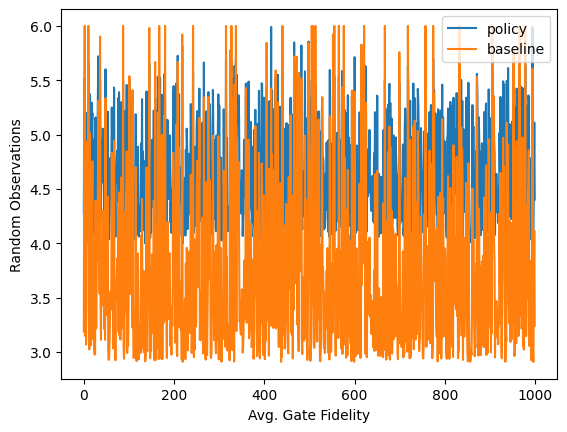

In [55]:
plt.plot(policy_reward, label='policy')
plt.plot(baseline_reward, label='baseline')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Random Observations')
plt.legend()
plt.show()

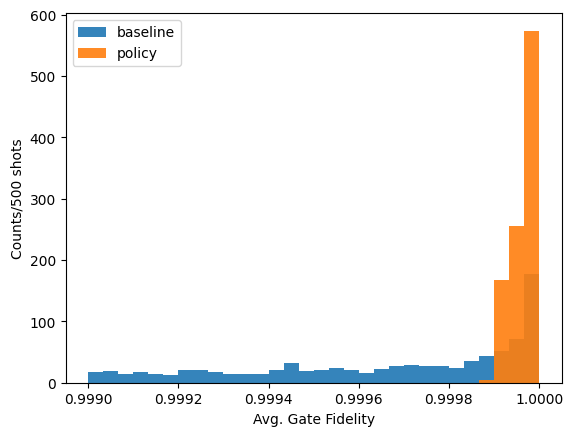

In [56]:
policy_fidelity = 1 - 10**(-np.array(policy_reward))
baseline_fidelity = 1 - 10**(-np.array(baseline_reward))
# baseline_fidelity = np.clip(baseline_fidelity, a_max=1 - 1e-5, a_min=None)

bins = np.linspace(0.999, 1, 31)  # 30 bins from 0 to 1
alpha = 0.9
plt.hist(baseline_fidelity, label='baseline', bins=bins, alpha=alpha)
plt.hist(policy_fidelity, label='policy', bins=bins, alpha=alpha)
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Counts/500 shots')
plt.legend()
plt.show()

In [57]:
import pandas as pd

In [58]:
df = pd.DataFrame({
    "policy": policy_fidelity,
    "baseline": baseline_fidelity
})

df.to_csv('fig results')

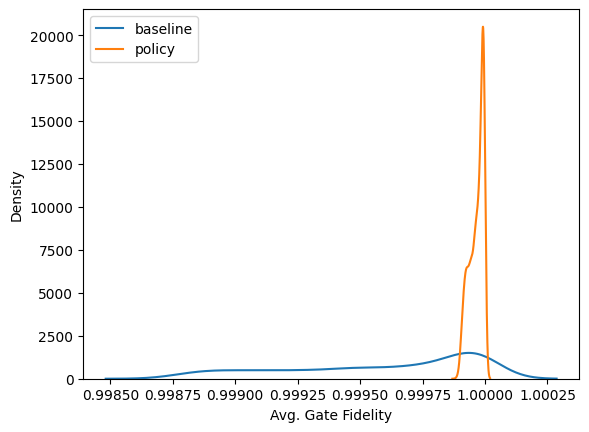

In [59]:
import seaborn as sns
sns.kdeplot(baseline_fidelity, label='baseline')
sns.kdeplot(policy_fidelity, label='policy')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Density')
plt.legend()
plt.show()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_9735/2473277318.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([baseline_fidelity, policy_fidelity], labels=['baseline', 'policy'])
/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_9735/2473277318.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


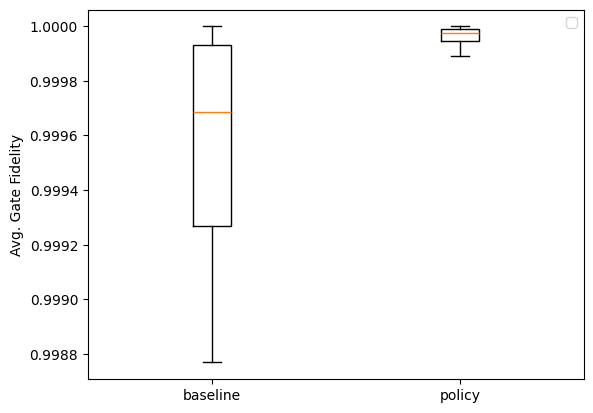

In [60]:
plt.boxplot([baseline_fidelity, policy_fidelity], labels=['baseline', 'policy'])
plt.ylabel('Avg. Gate Fidelity')
plt.legend()
plt.show()

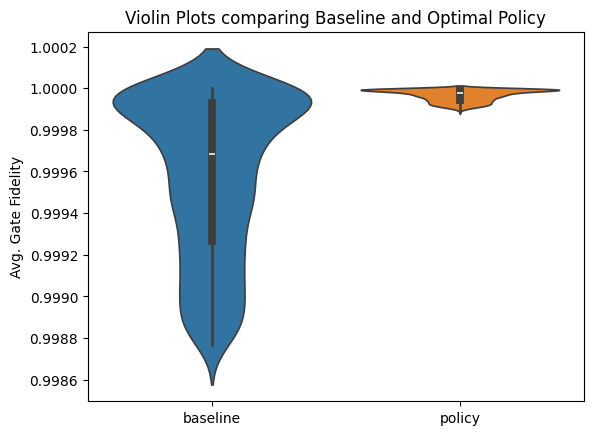

In [61]:
sns.violinplot(data=[baseline_fidelity, policy_fidelity], orient='v')
plt.xticks([0, 1], ['baseline', 'policy'])
plt.ylabel('Avg. Gate Fidelity')
plt.title('Violin Plots comparing Baseline and Optimal Policy')
plt.show()

In [62]:
# Calculating Numbers of Interest

ppo_agent.env.unwrapped.total_shots

[317312,
 336640,
 333312,
 361856,
 304000,
 195200,
 390400,
 201856,
 204928,
 192128,
 288384,
 275328,
 327040,
 304256,
 285312,
 393856,
 195328,
 211200,
 284928,
 284928,
 336512,
 330496,
 278400,
 295296,
 323200,
 201856,
 205184,
 201600,
 297600,
 358400,
 365056,
 214656,
 301056,
 217728,
 323840,
 297984,
 339840,
 224256,
 336384,
 201728,
 179456,
 332800,
 291200,
 285312,
 198528,
 192256,
 198656,
 307328,
 301312,
 185856,
 192128,
 320384,
 388096,
 314624,
 329984,
 204928,
 346368,
 198400,
 217728,
 211328,
 195200,
 204800,
 320000,
 294784,
 317184,
 323712,
 233728,
 281600,
 205056,
 192256,
 192128,
 221056,
 195328,
 230400,
 329856,
 204928,
 204800,
 339200,
 192128,
 300800,
 390784,
 204800,
 320384,
 205184,
 400256,
 220928,
 359040,
 333056,
 362112,
 214528,
 320000,
 224384,
 282240,
 326400,
 304000,
 201600,
 291584,
 204800,
 198400,
 211328,
 371840,
 185984,
 188800,
 337024,
 208128,
 288128,
 352000,
 198400,
 291328,
 288000,
 204800,
 

In [63]:
total_shots = np.array(ppo_agent.env.unwrapped.total_shots)

print(total_shots.shape)

(425,)


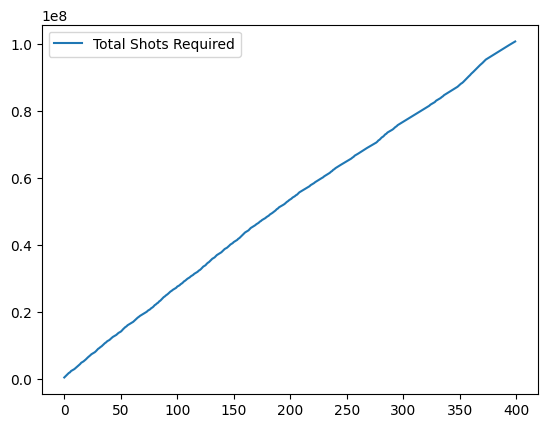

In [64]:
training_shots = total_shots[:400]

plt.plot(np.cumsum(training_shots), label='Total Shots Required')
plt.legend()
plt.show()

In [65]:
df_shots = pd.DataFrame({
    "cumulative shots": training_shots
})

df_shots.to_csv('training shots')

In [66]:
# Relevant Statistics

mean_policy_fidelity = np.mean(policy_fidelity)
std_policy_fidelity = np.std(policy_fidelity)

mean_baseline_fidelity = np.mean(baseline_fidelity)
std_baseline_fidelity = np.std(baseline_fidelity)

print(f"Mean Policy Fidelity: {mean_policy_fidelity} with sd: {std_policy_fidelity}")
print(f"Mean Baseline Fidelity: {mean_baseline_fidelity} with sd: {std_baseline_fidelity}")

Mean Policy Fidelity: 0.9999662968713567 with sd: 2.787783693929441e-05
Mean Baseline Fidelity: 0.9995773759077822 with sd: 0.00038138462907417526


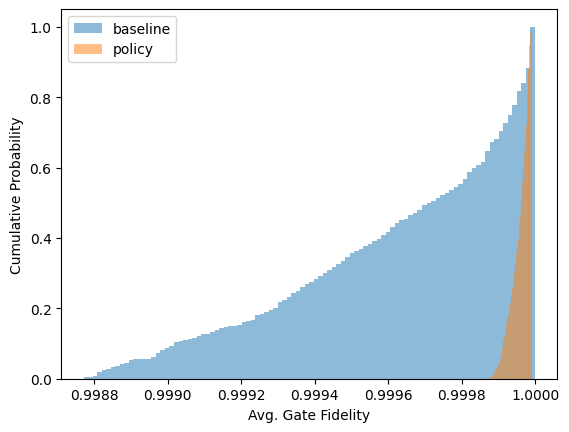

In [ ]:
plt.hist(baseline_fidelity, bins=100, cumulative=True, density=True, alpha=0.5, label='baseline')
plt.hist(policy_fidelity, bins=100, cumulative=True, density=True, alpha=0.5, label='policy')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## Testing New PPO Algo

In [ ]:
import uuid
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from gymnasium.spaces import Box
from typing import Dict, Optional, Any
import collections

# Adapted from CleanRL ppo_continuous_action.py
from rl_qoc.environment.base_q_env import BaseQuantumEnvironment

def process_action(self, probs: Normal):
    """
    Decide how actions should be processed before being sent to environment.
    For certain environments such as QUA, policy parameters should be streamed to the environment directly
    and actions are sampled within the environment (in real time).
    """
    action = probs.sample()
    logprob = probs.log_prob(action).sum(1)
    mean_action = probs.mean
    std_action = probs.stddev

    if isinstance(self.env, ActionWrapper):
        self.unwrapped_env.mean_action = self.env.action(mean_action[0].cpu().numpy())
    else:
        self.unwrapped_env.mean_action = mean_action[0].cpu().numpy()

    self.unwrapped_env.std_action = std_action[0].cpu().numpy()
    return action, logprob

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

def plot_curves(env: BaseQuantumEnvironment):
    """
    Plots the reward history, fidelity history, and (for moving_discrete) marginal reward and probability distributions for each qubit.
    """
    fidelity_range = [i * env.benchmark_cycle for i in range(len(env.fidelity_history))]
    num_qubits = len(env.unwrapped.applied_qubits)  # Number of qubits
    # Number of subplots: 2 for reward/fidelity, plus 2 per qubit for moving_discrete
    num_plots = 2 + (2 * num_qubits if env.unwrapped.circuit_param_distribution == "moving_discrete" else 0)
    fig, ax = plt.subplots(num_plots, 1, figsize=(8.0, 6.0 * num_plots), squeeze=False)
    ax = ax.flatten()

    # Plot average reward and fidelity history
    ax[0].plot(np.mean(env.reward_history, axis=1), label="Reward")
    ax[0].plot(
        fidelity_range,
        env.fidelity_history,
        label="Circuit Fidelity",
    )
    ax[0].set_title("Reward History")
    ax[0].legend()
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Reward")
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot RL reward history
    ax[1].plot(np.mean(env.reward_history, axis=1), label="RL Reward")
    ax[1].set_title("RL Reward History")
    ax[1].legend()
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("RL Reward")
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

    if env.unwrapped.circuit_param_distribution == "moving_discrete":
        # Single-qubit discrete values and their corresponding angles
        single_qubit_vals = env.unwrapped.single_qubit_discrete_obs_vals_raw
        angles = env.unwrapped.obs_raw_to_angles(single_qubit_vals)
        num_vals = len(single_qubit_vals)

        for qubit_idx in range(num_qubits):
            # Compute marginal reward distribution for this qubit
            marginal_rewards = np.zeros(num_vals)
            marginal_std = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                # Find indices where this qubit has the given value
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_rewards[i] = np.mean(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0
                marginal_std[i] = np.std(env.unwrapped.discrete_reward_history[:, mask]) if np.any(mask) else 0

            # Plot marginal reward history with error bars
            ax[2 + qubit_idx * 2].errorbar(
                angles,
                marginal_rewards,
                yerr=marginal_std,
                fmt='-o',
                label=f"Qubit {qubit_idx} Reward History",
            )
            ax[2 + qubit_idx * 2].set_title(f"Marginal Reward History (Qubit {qubit_idx})")
            ax[2 + qubit_idx * 2].legend()
            ax[2 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[2 + qubit_idx * 2].set_ylabel("Reward")

            # Compute marginal probability distribution
            marginal_probs = np.zeros(num_vals)
            for i, val in enumerate(single_qubit_vals):
                mask = np.isclose(env.unwrapped.discrete_obs_vals_raw[:, qubit_idx], val, rtol=1e-5, atol=1e-8)
                marginal_probs[i] = np.sum(env.unwrapped.prob_weights[mask]) if np.any(mask) else 0

            # Plot marginal probability weights
            ax[3 + qubit_idx * 2].scatter(
                angles,
                marginal_probs,
                label=f"Qubit {qubit_idx} Probability Weights",
            )
            ax[3 + qubit_idx * 2].set_title(f"Marginal Probability Weights (Qubit {qubit_idx})")
            ax[3 + qubit_idx * 2].legend()
            ax[3 + qubit_idx * 2].set_xlabel("Observation Value (Angles)")
            ax[3 + qubit_idx * 2].set_ylabel("Probability")
    
    plt.show()

class Agent(nn.Module):
    def __init__(
        self,
        env,
        use_combined_networks,
        activation_function_str,
        layer_size,
        robust_ppo,
    ):
        super().__init__()
        self.use_combined_networks = use_combined_networks
        self.robust_ppo = robust_ppo
        if activation_function_str == "tanh":
            self.activation_fn = nn.Tanh
        elif activation_function_str == "relu":
            self.activation_fn = nn.ReLU
        elif activation_function_str == "gelu":
            self.activation_fn = nn.GELU
        elif activation_function_str == "leaky_relu":
            self.activation_fn = nn.LeakyReLU
        elif activation_function_str == "elu":
            self.activation_fn = nn.ELU

        if not self.use_combined_networks:
            self.critic = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_mean = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
                layer_init(
                    nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01
                ),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )

        if self.use_combined_networks:
            self.main_network = nn.Sequential(
                layer_init(
                    nn.Linear(np.array(env.observation_space.shape).prod(), layer_size)
                ),
                self.activation_fn(),
                layer_init(nn.Linear(layer_size, layer_size)),
                self.activation_fn(),
            )
            self.actor_mean = nn.Sequential(
                self.main_network,
                layer_init(
                    nn.Linear(layer_size, np.prod(env.action_space.shape)), std=0.01
                ),
            )
            self.critic = nn.Sequential(
                self.main_network,
                layer_init(nn.Linear(layer_size, 1), std=1.0),
            )
            self.actor_logstd = nn.Parameter(
                torch.zeros(1, np.prod(env.action_space.shape))
            )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        return (
            action,
            probs.log_prob(action).sum(1),
            probs.entropy().sum(1),
            self.critic(x),
        )

class PPO_ContextBuffer:
    def __init__(
        self,
        agent_config: Dict,
        env: BaseQuantumEnvironment,
        chkpt_dir: Optional[str] = "tmp/ppo",
        chkpt_dir_critic: Optional[str] = "tmp/critic_ppo",
        num_warmup_updates: int = 100,
        context_buffer_size: int = 1000,
        noise_scale: float = 0.1,
    ):
        # General Run Params
        self.agent_config = agent_config
        self.exp_name = self.agent_config["exp_name"]
        self.seed = self.agent_config["seed"]
        self.torch_deterministic = self.agent_config["torch_deterministic"]
        self.cuda = self.agent_config["cuda"]
        self.track = self.agent_config["track"]
        self.wandb_project_name = self.agent_config["wandb_project_name"]
        self.wandb_entity = self.agent_config["wandb_entity"]
        self.save_model = self.agent_config["save_model"]
        self.plot_real_time = self.agent_config["plot_real_time"]
        self.num_prints = self.agent_config["num_prints"]

        # PPO Specific Params
        self.num_updates = self.agent_config["total_updates"]
        self.learning_rate = self.agent_config["learning_rate"]
        self.num_envs = self.agent_config["num_envs"]
        self.num_steps = self.agent_config["num_steps"]
        self.anneal_lr = self.agent_config["anneal_lr"]
        self.anneal_num_updates = self.agent_config["anneal_num_updates"]
        self.exp_anneal_lr = self.agent_config["exp_anneal_lr"]
        self.exp_update_time = self.agent_config["exp_update_time"]
        self.plateau_lr = self.agent_config["plateau_lr"]
        self.gamma = self.agent_config["gamma"]
        self.gae_lambda = self.agent_config["gae_lambda"]
        self.num_minibatches = self.agent_config["num_minibatches"]
        self.update_epochs = self.agent_config["update_epochs"]
        self.norm_adv = self.agent_config["norm_adv"]
        self.activation_function_str = self.agent_config["activation_function_str"]
        self.use_combined_networks = self.agent_config["use_combined_networks"]
        self.layer_size = self.agent_config["layer_size"]
        self.clip_coef = self.agent_config["clip_coef"]
        self.clip_vloss = self.agent_config["clip_vloss"]
        self.ent_coef = self.agent_config["ent_coef"]
        self.vf_coef = self.agent_config["vf_coef"]
        self.max_grad_norm = self.agent_config["max_grad_norm"]
        self.target_kl = self.agent_config["target_kl"]
        self.robust_ppo = self.agent_config["robust_ppo"]

        # Context Buffer Params
        self.num_warmup_updates = num_warmup_updates
        self.context_buffer_size = context_buffer_size
        self.noise_scale = noise_scale
        self.context_buffer = collections.deque()
        self.context_rewards = []
        self.context_history = []  # List to store (update_number, context) tuples

        self.batch_size = int(self.num_envs * self.num_steps)
        self.minibatch_size = int(self.batch_size // self.num_minibatches)

        assert (
            self.anneal_lr + self.exp_anneal_lr
        ), "Learning Rate Combination doesn't work"

        self.run_name = (
            f"PPO_ContextBuffer__{self.exp_name}__{self.seed}__{int(time.time())}"
        )

        if self.track:
            import wandb

            wandb.init(
                project=self.wandb_project_name,
                entity=self.wandb_entity,
                sync_tensorboard=True,
                config=self.agent_config,
                name=self.run_name,
                monitor_gym=True,
                save_code=True,
            )
        self.writer = SummaryWriter(f"runs/{self.run_name}")
        self.writer.add_text(
            "hyperparameters",
            "|param|value|\n|-|-|\n%s"
            % (
                "\n".join(
                    [f"|{key}|{value}|" for key, value in self.agent_config.items()]
                )
            ),
        )

        # Seeding
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = self.torch_deterministic

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() and self.cuda else "cpu"
        )
        self.env = env

        self.agent = Agent(
            self.env,
            self.use_combined_networks,
            self.activation_function_str,
            self.layer_size,
            self.robust_ppo,
        ).to(self.device)
        self.optimizer = optim.Adam(
            self.agent.parameters(), lr=self.learning_rate, eps=1e-5
        )

    def plot_context_history(self):
        updates, contexts = zip(*self.context_history)
        contexts = np.array(contexts)
        plt.figure(figsize=(10, 6))
        for i in range(contexts.shape[1]):
            plt.plot(updates, contexts[:, i], label=f"Context Dim {i}")
        plt.xlabel("Update")
        plt.ylabel("Context Value")
        plt.title("Context Sampling History")
        plt.legend()
        plt.show()

    def add_to_context_buffer(self, context, reward):
        """Add context-reward pair to buffer and maintain size"""
        print(f"Before append: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}")
        self.context_buffer.append(context)
        self.context_rewards.append(reward)
        if len(self.context_buffer) > self.context_buffer_size:
            self.context_buffer.popleft()
            print(f"context rewards before: {self.context_rewards}")
            self.context_rewards.pop(0)
            print(f"context rewards after: {self.context_rewards}")
        print(f"After append: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}")
        assert len(self.context_buffer) == len(self.context_rewards), \
            f"Buffer length mismatch: context_buffer={len(self.context_buffer)}, context_rewards={len(self.context_rewards)}"

    def sample_context(self, warmup=False):
        """Sample context from buffer or randomly during warmup"""
        if warmup or len(self.context_buffer) == 0:
            return np.random.uniform(
                self.env.observation_space.low,
                self.env.observation_space.high,
                self.env.observation_space.shape,
            )
        else:
            # Create probability distribution based on inverse rewards
            rewards = np.array(self.context_rewards)
            # Avoid division by zero and handle negative rewards
            rewards = np.clip(rewards, a_min=1e-6, a_max=None)
            prob_weights = 1.0 / rewards
            prob_weights = prob_weights / np.sum(prob_weights)

            # Sample context from buffer
            idx = np.random.choice(len(self.context_buffer), p=prob_weights)
            context = self.context_buffer[idx]

            # Add noise to sampled context
            noise = np.random.normal(0, self.noise_scale, context.shape)
            noisy_context = context + noise
            # Clip to observation space bounds
            noisy_context = np.clip(
                noisy_context,
                self.env.observation_space.low,
                self.env.observation_space.high,
            )

            return noisy_context

    def run_training(self):
        # Storage setup
        self.obs = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.observation_space.shape
        ).to(self.device)
        self.actions = torch.zeros(
            (self.num_steps, self.num_envs) + self.env.action_space.shape
        ).to(self.device)
        self.logprobs = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.rewards = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.dones = torch.zeros((self.num_steps, self.num_envs)).to(self.device)
        self.values = torch.zeros((self.num_steps, self.num_envs)).to(self.device)

        # Start training
        global_step = 0
        start_time = time.time()

        for update in range(1, self.num_updates + 1):
            # Determine if in warmup phase
            is_warmup = update <= self.num_warmup_updates

            # Sample new context
            context = self.sample_context(warmup=is_warmup)
            # Store context in history
            self.context_history.append((update, context.copy()))

            # Reset environment with sampled context
            next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
            next_obs = np.tile(next_obs, (self.num_envs, 1))
            next_obs = torch.Tensor(next_obs).to(self.device)
            next_done = torch.zeros(self.num_envs).to(self.device)

            # Annealing the Learning Rate
            if self.anneal_lr or self.exp_anneal_lr:
                if self.anneal_lr:
                    frac = 1.0 - (update - 1.0) / self.anneal_num_updates
                    lrnow = (
                        np.clip(frac, a_min=0.0, a_max=None) * self.learning_rate
                        + self.plateau_lr
                    )
                    self.optimizer.param_groups[0]["lr"] = lrnow
                if self.exp_anneal_lr:
                    lrnow = (
                        self.learning_rate * np.exp(-update / self.exp_update_time)
                        + self.plateau_lr
                    )
                    self.optimizer.param_groups[0]["lr"] = lrnow

            for step in range(0, self.num_steps):
                global_step += self.num_envs
                self.obs[step] = next_obs
                self.dones[step] = next_done

                # Action logic
                with torch.no_grad():
                    action, logprob, _, value = self.agent.get_action_and_value(
                        next_obs
                    )
                    self.values[step] = value.flatten()
                self.actions[step] = action
                self.logprobs[step] = logprob

                # Execute step
                cpu_action = action.cpu().numpy()
                mean_action = np.mean(cpu_action, axis=0)
                self.env.unwrapped.mean_action = self.env.action(mean_action)

                next_obs, reward, terminations, truncations, infos = self.env.step(
                    cpu_action
                )
                print(f"Mean Action: {np.mean(cpu_action, axis=0)}")

                # Add to context buffer
                mean_reward = np.mean(reward)
                self.add_to_context_buffer(context, mean_reward)

                next_obs = np.tile(next_obs, (self.num_envs, 1))
                next_done = np.logical_or(terminations, truncations)
                if next_done.any():
                    context = self.sample_context(warmup=is_warmup)
                    self.context_history.append((update, context.copy()))
                    next_obs, _ = self.env.unwrapped.reset(debug_obs=context)
                    next_obs = np.tile(next_obs, (self.num_envs, 1))

                self.rewards[step] = torch.tensor(reward).to(self.device).view(-1)
                next_obs, next_done = torch.Tensor(next_obs).to(
                    self.device
                ), torch.Tensor(next_done).to(self.device)

                if "final_info" in infos:
                    for info in infos["final_info"]:
                        if info and "episode" in info:
                            print(
                                f"global_step={global_step}, episodic_return={info['episode']['r']}"
                            )
                            self.writer.add_scalar(
                                "charts/episodic_return",
                                info["episode"]["r"],
                                global_step,
                            )
                            self.writer.add_scalar(
                                "charts/episodic_length",
                                info["episode"]["l"],
                                global_step,
                            )

            # Bootstrap value
            with torch.no_grad():
                next_value = self.agent.get_value(next_obs).reshape(1, -1)
                advantages = torch.zeros_like(self.rewards).to(self.device)
                lastgaelam = 0
                for t in reversed(range(self.num_steps)):
                    if t == self.num_steps - 1:
                        nextnonterminal = 1.0 - next_done
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - self.dones[t + 1]
                        nextvalues = self.values[t + 1]
                    delta = (
                        self.rewards[t]
                        + self.gamma * nextvalues * nextnonterminal
                        - self.values[t]
                    )
                    advantages[t] = lastgaelam = (
                        delta
                        + self.gamma * self.gae_lambda * nextnonterminal * lastgaelam
                    )
                returns = advantages + self.values

            # Flatten batch
            b_obs = self.obs.reshape((-1,) + self.env.observation_space.shape)
            b_logprobs = self.logprobs.reshape(-1)
            b_actions = self.actions.reshape((-1,) + self.env.action_space.shape)
            b_advantages = advantages.reshape(-1)
            b_returns = returns.reshape(-1)
            b_values = self.values.reshape(-1)

            # Optimize policy and value network
            b_inds = np.arange(self.batch_size)
            clipfracs = []
            for epoch in range(self.update_epochs):
                np.random.shuffle(b_inds)
                for start in range(0, self.batch_size, self.minibatch_size):
                    end = start + self.minibatch_size
                    mb_inds = b_inds[start:end]

                    _, newlogprob, entropy, newvalue = self.agent.get_action_and_value(
                        b_obs[mb_inds], b_actions[mb_inds]
                    )
                    logratio = newlogprob - b_logprobs[mb_inds]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clipfracs += [
                            ((ratio - 1.0).abs() > self.clip_coef).float().mean().item()
                        ]

                    mb_advantages = b_advantages[mb_inds]
                    if self.norm_adv:
                        mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                            mb_advantages.std() + 1e-8
                        )

                    # Policy loss
                    pg_loss1 = -mb_advantages * ratio
                    pg_loss2 = -mb_advantages * torch.clamp(
                        ratio, 1 - self.clip_coef, 1 + self.clip_coef
                    )
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    # Value loss
                    newvalue = newvalue.view(-1)
                    if self.clip_vloss:
                        v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                        v_clipped = b_values[mb_inds] + torch.clamp(
                            newvalue - b_values[mb_inds],
                            -self.clip_coef,
                            self.clip_coef,
                        )
                        v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                        v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                        v_loss = 0.5 * v_loss_max.mean()
                    else:
                        v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

                    entropy_loss = entropy.mean()
                    loss = (
                        pg_loss - self.ent_coef * entropy_loss + v_loss * self.vf_coef
                    )

                    self.optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(
                        self.agent.parameters(), self.max_grad_norm
                    )
                    self.optimizer.step()

                if self.target_kl is not None and approx_kl > self.target_kl:
                    break

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = (
                np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
            )

            # Log metrics
            self.writer.add_scalar(
                "charts/learning_rate",
                self.optimizer.param_groups[0]["lr"],
                global_step,
            )
            self.writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
            self.writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
            self.writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
            self.writer.add_scalar(
                "losses/old_approx_kl", old_approx_kl.item(), global_step
            )
            self.writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
            self.writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
            self.writer.add_scalar(
                "losses/explained_variance", explained_var, global_step
            )
            print("SPS:", int(global_step / (time.time() - start_time)))
            self.writer.add_scalar(
                "charts/SPS", int(global_step / (time.time() - start_time)), global_step
            )

            if global_step % self.num_prints == 0:
                from IPython.display import clear_output

                clear_output(wait=True)
                if self.plot_real_time:
                    plot_curves(self.env.unwrapped)

        if self.save_model:
            model_path = f"runs/{self.run_name}/{self.exp_name}.cleanrl_model"
            torch.save(self.agent.state_dict(), model_path)
            print(f"model saved to {model_path}")

        self.env.close()
        self.writer.close()

In [ ]:
# PPO Contextual Details

train_env = GeneralAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix,
    num_params=5,
    discrete_history_length=3,
    applied_qubits=[2, 4],
    circuit_param_distribution="uniform",
    optimal_error_precision=1e-4,
    obs_bounds=(0., np.pi)
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-4,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 800,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.01,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
    
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(train_env, min_action=-1., max_action=1.)
ppo_agent = PPO_ContextBuffer(
    agent_config, 
    rescaled_q_env,
    num_warmup_updates=20,
    context_buffer_size=50,
    noise_scale=0.15
)

Observation Vals for Agent: [[-1.  -1. ]
 [-0.5 -0.5]
 [ 0.   0. ]
 [ 0.5  0.5]
 [ 1.   1. ]]
Observation Vals for Env: [[0.         0.        ]
 [0.78539816 0.78539816]
 [1.57079633 1.57079633]
 [2.35619449 2.35619449]
 [3.14159265 3.14159265]]


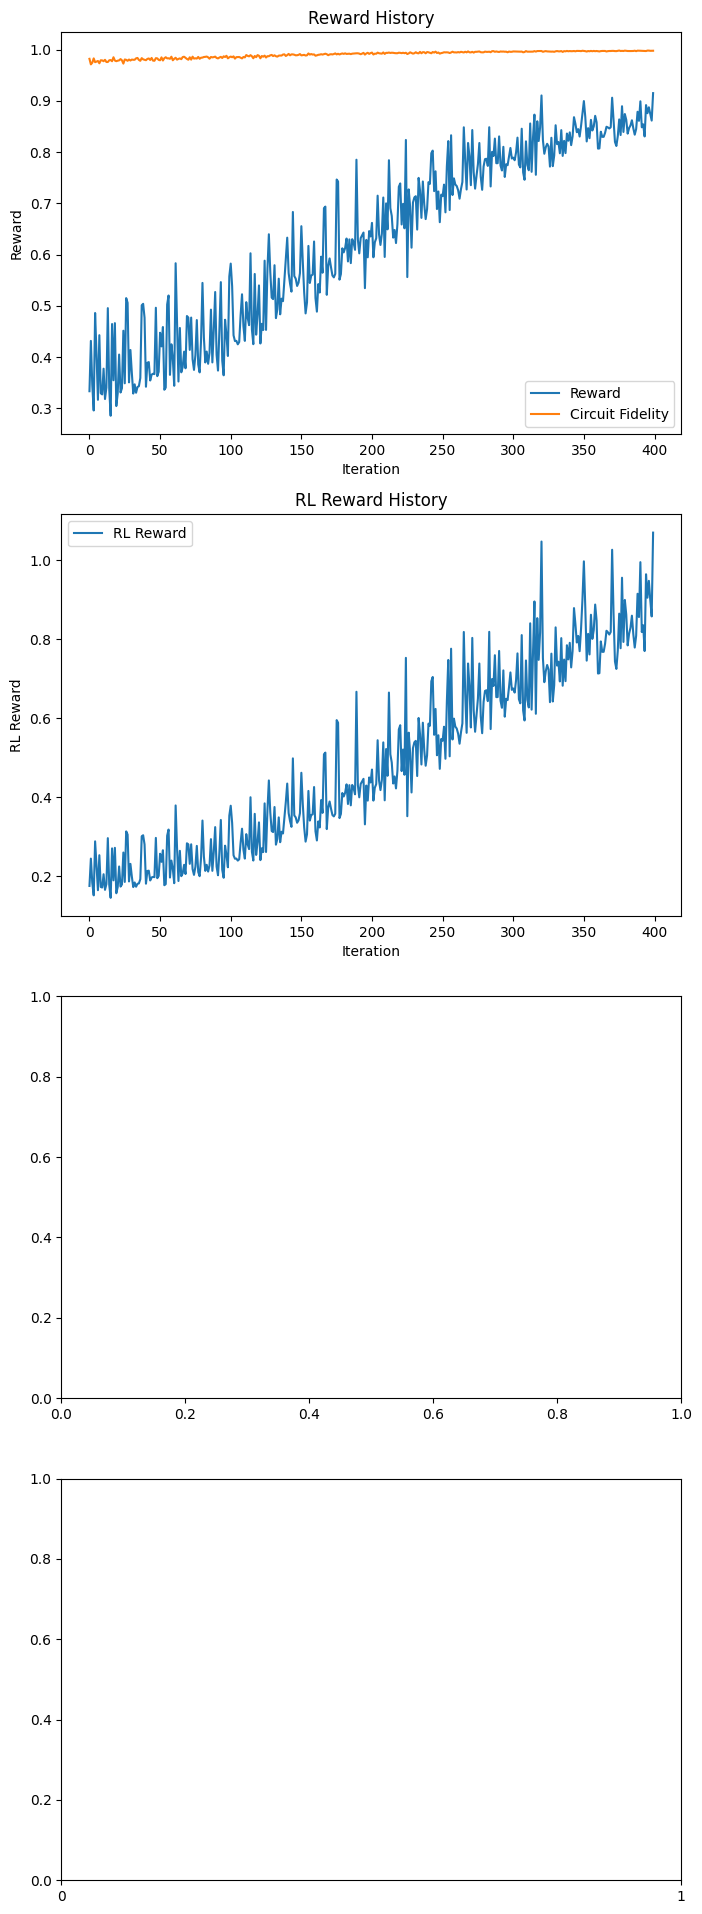

model saved to runs/PPO_ContextBuffer__Test PPO CleanRL__1__1747207219/Test PPO CleanRL.cleanrl_model


In [ ]:
ppo_agent.run_training()

In [ ]:
NUM_EVAL = 20
import torch

action_list = []
obs_list = []
reward_list = []

for n in range(NUM_EVAL):
    obs, _ = ppo_agent.env.reset()
    obs_list.append(obs)
    batch_obs = np.tile(obs, (32, 1))
    with torch.no_grad():
        batch_action, logprob, _, value = ppo_agent.agent.get_action_and_value(
            torch.Tensor(batch_obs)
        )
    next_obs, reward, terminations, truncations, infos = ppo_agent.env.step(
        batch_action.numpy()
    )
    reward_list.append(np.mean(reward))
    mean_action = np.mean(batch_action.numpy(), axis=0)
    action_list.append(mean_action)

Sampled angles:  [0.         0.         0.2164929  0.         1.47701588 0.        ]
Environment Observation: [-0.86217634 -0.05970249]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9976491304151731
Reward (avg): 0.8699714375478971 Std: 0.06519839822324694
obs: [-0.86217634 -0.05970249]
reward: [0.93561586 0.63665447 1.06095929 0.62285157 0.73356138 0.72226828
 1.53422736 0.72066435 0.85018142 0.90313822 1.03018539 0.7770996
 1.15013734 0.81363067 0.77701592 0.965376   0.77110508 1.45431379
 0.72269937 1.23856097 0.91972679 0.90155175 0.78296798 1.13658283
 0.64545563 0.59288443 2.11377814 1.13934472 1.50047404 0.8158455
 1.26081708 0.87760426]
Sampled angles:  [0.         0.         1.57032666 0.         0.6232791  0.        ]
Environment Observation: [-2.98998108e-04 -6.03208200e-01]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975203730340991
Reward (avg): 0.9050450909440346 Std: 0.06949879621294809
obs: [-2.98998108e-04 -6.03208200e-01]
reward: [1.38424298 1.23894662 1.13811453 0.78785223 1.2420538  1.31975402
 1.93464185 1.43689434 0.65582454 1.0061157  1.38583296 1.48936558
 0.97020686 0.7882655  1.37521788 1.25129265 0.69294012 0.73079604
 0.82026052 1.66948678 1.11455634 1.18869643 1.35780773 1.53540888
 0.91760452 0.96458014 0.86575469 0.53023229 1.52061409 0.67954629
 1.29397696 1.2027811 ]
Sampled angles:  [0.         0.         0.15642563 0.         1.36588285 0.        ]
Environment Observation: [-0.90041635 -0.13045197]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975695989398856
Reward (avg): 0.8633405325880592 Std: 0.07059312442359661
obs: [-0.90041635 -0.13045197]
reward: [1.16505542 0.81620986 0.82713326 0.56253587 0.59504426 1.08724743
 0.73901282 0.80364271 1.46491564 0.88590064 0.87877318 1.1435851
 0.95923267 0.99468301 1.2001987  0.79268134 1.05409962 0.8486826
 1.33044686 1.01254377 0.94431215 0.69440788 0.93798666 1.04991775
 0.63130273 0.8456001  0.76081195 0.87197497 1.01665413 0.45702583
 1.58920865 0.69720738]
Sampled angles:  [0.         0.         2.55693925 0.         0.908511   0.        ]
Environment Observation: [ 0.62779808 -0.42162394]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9914490332780077
Reward (avg): 0.8418325704126726 Std: 0.10544907355137789
obs: [ 0.62779808 -0.42162394]
reward: [1.29417378 1.11242152 0.56969524 1.0889668  1.21473753 0.50311578
 0.54993039 1.12930205 1.20004795 1.03361481 1.167844   0.81084281
 1.47273623 0.67993    0.54634654 1.20396982 0.36934713 1.01173804
 0.76272637 1.01749981 0.43776558 0.71198617 1.27867985 1.20084059
 0.7347251  0.78834965 0.49399553 1.18030533 0.56190548 0.96925684
 0.94325822 0.72861586]
Sampled angles:  [0.         0.         2.43507824 0.         2.82580798 0.        ]
Environment Observation: [0.55021896 0.79896523]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.993331380954558
Reward (avg): 0.6321996167462929 Std: 0.12818447134399646
obs: [0.55021896 0.79896523]
reward: [0.34368325 0.40662518 1.29608304 0.56487447 0.56301749 0.21838261
 0.49205534 0.63885253 0.44259612 0.25108065 0.30799805 0.58618053
 0.38018788 0.36599776 0.40990107 0.78649096 0.64046748 0.39880348
 0.43461712 0.40485735 0.65243279 0.43688749 0.57549972 0.31211009
 0.47326495 0.18977804 0.27770789 0.70140693 0.4053507  0.36230607
 0.3774433  0.38520333]
Sampled angles:  [0.         0.         0.62567564 0.         1.37926615 0.        ]
Environment Observation: [-0.60168251 -0.1219319 ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972267878886539
Reward (avg): 0.8700701515300917 Std: 0.09487145498656539
obs: [-0.60168251 -0.1219319 ]
reward: [0.54395549 1.27500907 1.09504172 1.23389862 0.75418263 1.35852089
 1.57338629 0.57907895 0.92038617 1.24968799 1.23673598 1.29428388
 1.31997669 1.06818288 1.74301793 0.78735777 1.43232203 1.05715506
 0.60168142 0.64940058 1.04311205 0.36039801 0.84267773 1.17488057
 0.73125305 1.10000427 0.67936541 0.69762285 0.75749472 1.48504144
 0.93357266 0.62888421]
Sampled angles:  [0.         0.         2.03637745 0.         2.10946835 0.        ]
Environment Observation: [0.29639815 0.34292926]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9901534918988826
Reward (avg): 0.732308986674235 Std: 0.1478533798750284
obs: [0.29639815 0.34292926]
reward: [0.29381903 0.78702747 0.56592586 0.85639849 0.4518993  0.34570518
 0.96313029 0.30242252 1.21439105 0.53230666 0.77963147 0.93155472
 0.36565816 0.70398162 0.76820701 0.65145985 1.0804536  0.70945982
 0.56198404 0.64870966 0.46942512 0.35973925 0.30462179 0.60771558
 1.18800864 1.03693687 0.83478629 0.73732559 0.38494198 0.72628616
 0.32945117 0.25040663]
Sampled angles:  [0.         0.         3.11950842 0.         2.39698394 0.        ]
Environment Observation: [0.98594074 0.52596737]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9919915432347077
Reward (avg): 0.538879766208108 Std: 0.1272853417723552
obs: [0.98594074 0.52596737]
reward: [0.54707737 0.31759698 0.29372386 0.48332496 0.28453912 0.29270639
 0.28293405 0.60126449 0.19290695 0.17810385 0.3207655  0.1931818
 0.49340546 0.62872139 0.30047188 0.32044646 0.34788611 0.15572816
 0.47242715 0.47223763 0.40324015 0.35288867 0.19471588 0.17392658
 0.51186962 0.32323218 0.4970599  0.34580634 0.24894561 0.45095579
 0.30730504 0.33492045]
Sampled angles:  [0.         0.         0.50636381 0.         2.13649927 0.        ]
Environment Observation: [-0.67763879  0.36013768]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972920334720219
Reward (avg): 0.8676175264242567 Std: 0.06544564631298526
obs: [-0.67763879  0.36013768]
reward: [0.85728296 0.83308961 1.05951352 1.07933911 0.65060296 0.81216038
 0.75575432 0.69575591 1.27356216 0.81609419 0.69403925 0.82905746
 1.28413305 0.9241748  0.80559167 0.76239348 0.73115468 1.62088869
 0.92884122 0.706355   1.95786915 0.60361082 0.83251693 1.32213319
 1.31197382 0.85029968 0.58758227 0.85703375 0.81967268 1.98692998
 0.79879223 1.08883065]
Sampled angles:  [0.         0.         0.49188157 0.         2.04312154 0.        ]
Environment Observation: [-0.68685846  0.30069157]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.997031716074736
Reward (avg): 0.8711683126877943 Std: 0.07706194371340049
obs: [-0.68685846  0.30069157]
reward: [0.90109999 0.6922706  0.77029477 1.12959182 1.56037503 0.663452
 0.58605181 0.82279846 0.90819521 1.07237817 2.13489337 1.0053511
 0.72298585 0.85276865 0.86268383 0.80330049 1.39119818 1.1217421
 0.81397962 0.60699581 1.19788444 0.41285089 1.17598898 0.87550734
 1.63740685 0.85338027 0.95905148 1.11141914 1.23793478 0.77263665
 0.92683387 1.02097065]
Sampled angles:  [0.         0.         2.83246661 0.         1.52647533 0.        ]
Environment Observation: [ 0.80320425 -0.02821562]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9920657267165632
Reward (avg): 0.7034923164113625 Std: 0.13539286929809116
obs: [ 0.80320425 -0.02821562]
reward: [0.65405699 0.23100689 0.45770393 0.39866308 0.45785653 0.82060662
 0.38696005 0.37726748 0.50820887 0.42053292 0.35400018 0.80940984
 0.68455618 0.44719893 0.49708928 0.43594704 0.82542873 0.32071562
 0.48828943 1.3162274  0.67267234 0.75088039 0.31002095 0.2722406
 0.49631619 1.052711   0.97341992 0.61030744 1.10330431 0.61631173
 0.5220955  0.56787528]
Sampled angles:  [0.         0.         2.70553463 0.         0.35292779 0.        ]
Environment Observation: [ 0.72239684 -0.77531919]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.992901511600963
Reward (avg): 0.8161792406116768 Std: 0.09233608769183708
obs: [ 0.72239684 -0.77531919]
reward: [1.21593828 0.84288474 0.58368981 0.87953432 0.59252756 1.16490783
 0.43006376 0.84035222 0.62887568 0.39342567 0.9986302  0.6549234
 0.85575301 0.64030745 0.80570414 0.53905328 0.83698169 0.86204137
 0.40378365 1.53550353 0.76614173 0.80464091 0.74123597 0.74402545
 0.93269495 1.1432054  0.84355337 0.56605459 0.7090918  0.83174834
 0.59981866 1.11748272]
Sampled angles:  [0.         0.         1.25553486 0.         0.849914   0.        ]
Environment Observation: [-0.20070169 -0.45892794]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9972454228599539
Reward (avg): 0.9066131756843657 Std: 0.061298129325668055
obs: [-0.20070169 -0.45892794]
reward: [2.69204426 1.26512288 1.03567725 0.92864349 0.85296915 1.38952415
 0.98086283 0.677261   0.77702661 0.66479474 1.14837728 1.310596
 1.50192032 0.8306258  0.73344103 1.18540173 1.05297588 1.2546263
 1.35895376 1.72981292 0.79240578 1.35005101 1.06107303 1.53236086
 1.4054748  1.68880474 1.14580377 0.89207173 0.6337452  0.89124399
 1.11092857 1.17332861]
Sampled angles:  [0.         0.         2.80586808 0.         0.07664607 0.        ]
Environment Observation: [ 0.7862711 -0.9512056]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9943219790142922
Reward (avg): 0.8265533638926255 Std: 0.11130266851817873
obs: [ 0.7862711 -0.9512056]
reward: [0.48129232 0.82275244 0.64599447 1.58512077 0.57991085 0.89137577
 1.04130141 0.72820729 0.32203827 1.19751215 1.3900631  0.55148796
 0.89077254 0.70385721 1.51913673 1.14430945 0.76845692 1.19801496
 0.53158668 0.42907375 0.79705321 0.67623704 1.29922584 1.01770979
 0.7453564  0.54217032 0.58195277 0.98009056 1.49123561 0.78099013
 1.04767497 0.49323845]
Sampled angles:  [0.         0.         0.12685697 0.         2.59708811 0.        ]
Environment Observation: [-0.91924035  0.65335764]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9964679811608821
Reward (avg): 0.7988877515739297 Std: 0.10608728730188853
obs: [-0.91924035  0.65335764]
reward: [0.48642136 0.46993024 0.47232523 0.9245202  0.50919957 0.63551579
 1.28634065 0.49822724 0.75442225 0.61330009 0.475223   1.0852405
 0.59677449 1.203591   1.06837649 0.81155192 0.77190756 0.73315474
 0.49295962 0.9357907  1.08739498 1.39328367 0.52368976 0.42613712
 0.82252464 0.83954388 0.82816531 0.81281304 0.75674915 1.05354979
 0.37400466 0.85208119]
Sampled angles:  [0.         0.         2.01814332 0.         2.44459109 0.        ]
Environment Observation: [0.28478994 0.55627502]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9911807680944271
Reward (avg): 0.7018581854302011 Std: 0.12333892593761914
obs: [0.28478994 0.55627502]
reward: [0.51891188 0.42493048 0.5045379  0.42513931 0.4308739  0.55223993
 0.416522   0.62495047 1.09278424 0.49590526 0.87995453 0.76374715
 0.79352875 0.34756939 0.39174412 0.65446877 0.32468642 0.75029714
 0.4941221  0.4758922  0.97168731 0.24636409 0.3730108  0.64722762
 0.26405612 0.55923349 0.73853154 0.60970534 0.53412644 0.35125257
 0.75102728 0.77550975]
Sampled angles:  [0.         0.         2.36703013 0.         1.76161428 0.        ]
Environment Observation: [0.50689818 0.12147848]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9893154325952453
Reward (avg): 0.7297157384113432 Std: 0.14001293410029816
obs: [0.50689818 0.12147848]
reward: [0.64512426 0.44812033 0.93429149 0.43952588 0.45500158 0.69485289
 0.82203481 0.43133175 0.75302029 0.94206754 0.40620724 0.53357611
 0.9773366  0.24021679 0.38059716 0.4061943  0.97120842 1.33363694
 0.50225766 0.4540843  0.23785078 0.44817038 0.2880924  0.64621108
 0.53055105 0.87102348 0.7504398  0.56822967 0.60101256 1.2457
 0.61306567 0.90556761]
Sampled angles:  [0.         0.         2.03076828 0.         0.53542322 0.        ]
Environment Observation: [ 0.29282724 -0.65913899]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9964780133792598
Reward (avg): 0.8949322388045419 Std: 0.08252738771950001
obs: [ 0.29282724 -0.65913899]
reward: [0.75652432 0.91890071 0.79791389 1.66298099 1.6381001  0.99306963
 1.27126427 1.3792531  1.3100905  0.56306227 0.83915899 1.42790578
 1.04077074 1.11724974 1.04621752 1.19508959 1.31907111 0.88035358
 1.05272714 0.99511131 1.50167106 1.37282924 0.7803508  1.09271297
 0.87990216 1.28845331 0.36488715 0.85325487 1.65183386 0.8779777
 0.70827024 1.35331022]
Sampled angles:  [0.         0.         0.64415719 0.         2.72759051 0.        ]
Environment Observation: [-0.5899168   0.73643805]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9950574923441968
Reward (avg): 0.7755178074020517 Std: 0.14839967081249233
obs: [-0.5899168   0.73643805]
reward: [0.19612069 0.92734187 0.99918675 0.32163661 0.57375522 0.94018432
 0.79447584 0.98504602 0.47090967 0.89578291 1.3404255  0.42670599
 0.33100414 0.97258819 1.10558594 0.42573746 0.67586106 0.56997613
 1.04218293 0.57492998 0.57504668 0.38919626 1.57645357 1.07789687
 0.84961767 1.58466239 0.59278451 0.8482956  0.45194654 0.6558385
 0.41456912 0.82692041]
Sampled angles:  [0.         0.         0.17995028 0.         2.17348574 0.        ]
Environment Observation: [-0.88544009  0.383684  ]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelities (per Cycle):  0.9975087597712382
Reward (avg): 0.8580074215152703 Std: 0.09063184664643507
obs: [-0.88544009  0.383684  ]
reward: [0.81601615 1.16838694 0.87820907 0.93413152 1.0630912  1.1478729
 1.08603602 0.71215381 0.77668533 0.41311119 0.77393897 1.03556751
 0.92773465 0.68154592 0.62283133 0.8427408  0.85130518 1.43360948
 0.7455245  0.43465051 0.72447883 0.53346947 1.26476083 0.57798589
 0.88276387 1.35829685 1.12882691 0.82161591 1.75839673 1.6492271
 1.24282498 1.01462721]


/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_91054/3013701159.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


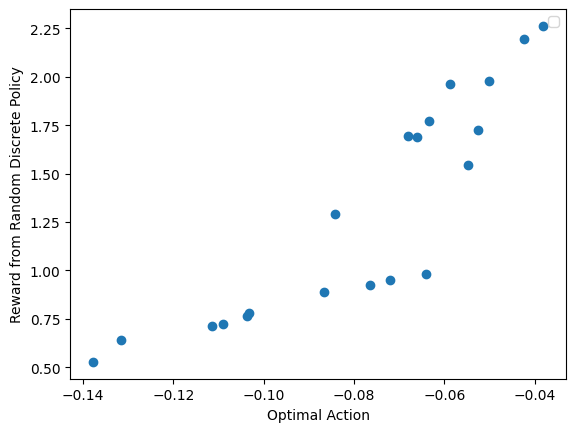

In [ ]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1)

plt.scatter(optimal_action, reward_list)
plt.xlabel('Optimal Action')
plt.ylabel('Reward from Random Discrete Policy')
plt.legend()
plt.show()

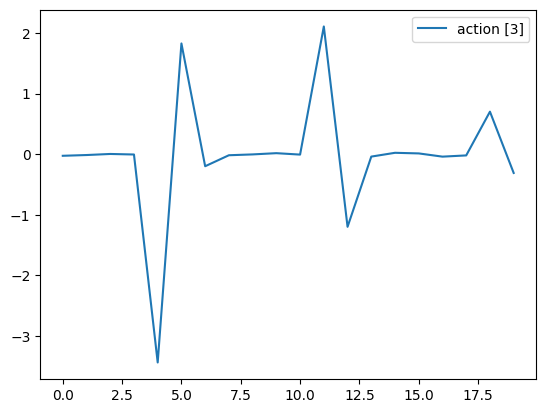

In [ ]:
action_arr = np.array(action_list)
action_arr = action_arr.reshape(7, -1)

for i in range(len(action_arr)):
    if i == 3:
        plt.plot(action_arr[i], label=f'action [{i}]')
plt.legend()
plt.show()

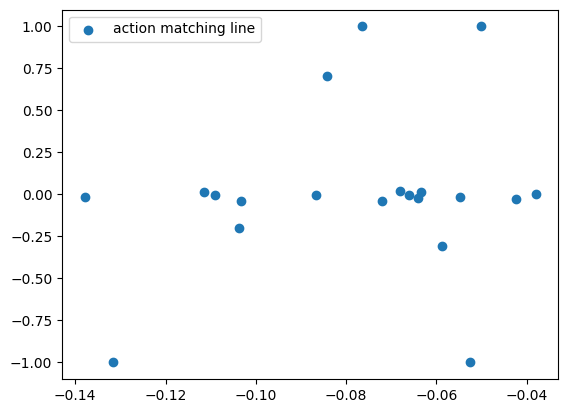

In [ ]:
obs_arr = np.array(obs_list)
weighted_obs_arr = 0.5 * (obs_arr + 1) * np.pi * gamma_matrix[[2, 4], 3].reshape(1, -1)
optimal_action = -np.sum(weighted_obs_arr, axis=-1)

action_relevant = action_arr[3]

plt.scatter(optimal_action, np.clip(action_relevant, a_min=-1., a_max=1.), label='action matching line')
plt.legend()
plt.show()

In [ ]:
ppo_agent.context_history

[(1, array([-0.16595599,  0.44064899])),
 (1, array([-0.99977125, -0.39533485])),
 (2, array([0.96351328, 0.78604242])),
 (2, array([0.51869759, 0.30224112])),
 (3, array([ 0.58074705, -0.56500156])),
 (3, array([-0.59958201,  0.36088013])),
 (4, array([ 0.04559206, -0.67612421])),
 (4, array([ 0.89795404, -0.88110185])),
 (5, array([0.96151755, 0.37312636])),
 (5, array([ 0.83989446, -0.86120808])),
 (6, array([-0.68637962, -0.22276715])),
 (6, array([ 0.00531339, -0.66873483])),
 (7, array([-0.04283956, -0.83730619])),
 (7, array([-0.15631585, -0.69895618])),
 (8, array([-0.82365264, -0.52984473])),
 (8, array([-0.07679584, -0.60281699])),
 (9, array([-0.33574141,  0.26698015])),
 (9, array([0.34682874, 0.25640249])),
 (10, array([-0.13232035, -0.88128555])),
 (10, array([-0.0145548 , -0.06973211])),
 (11, array([ 0.66031305, -0.51980969])),
 (11, array([0.26324149, 0.42147914])),
 (12, array([0.13031305, 0.56270671])),
 (12, array([ 0.89739964, -0.52274398])),
 (13, array([0.1539556

In [ ]:
arr_context_history = [tup[1] for tup in ppo_agent.context_history]

In [ ]:
arr_context_history = np.array(arr_context_history)

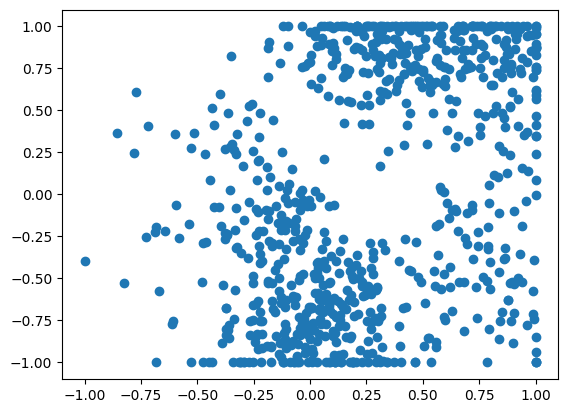

In [ ]:
plt.scatter(arr_context_history[:,0], arr_context_history[:,1])
plt.show()

In [ ]:
ppo_agent.context_buffer

deque([array([ 0.10619722, -0.61551116]),
       array([ 0.13414905, -0.74905663]),
       array([-0.2799765 ,  0.43519099]),
       array([0.94388785, 1.        ]),
       array([0.19282882, 0.98849365]),
       array([-0.100027  , -0.04907671]),
       array([ 0.0385331, -0.6241202]),
       array([-0.6132612, -0.7731658]),
       array([-0.02031739, -0.90850852]),
       array([0.23504669, 0.72672121]),
       array([-0.31687566, -1.        ]),
       array([0.07989888, 1.        ]),
       array([0.82640957, 1.        ]),
       array([-0.11696827, -0.82605574]),
       array([0.20592003, 1.        ]),
       array([ 0.07772967, -0.6258654 ]),
       array([-0.42528138,  0.41616216]),
       array([-0.18999862,  0.02648732]),
       array([-0.35558355,  0.28065835]),
       array([-0.25149187, -0.74515565]),
       array([-0.1083617, -0.7985142]),
       array([-0.43506494,  0.51768172]),
       array([-0.47560797, -1.        ]),
       array([0.71183925, 0.75732465]),
       array

In [ ]:
sample_context_list = []

for i in range(100):
    sample_context = ppo_agent.sample_context(warmup=False)
    sample_context_list.append(sample_context)

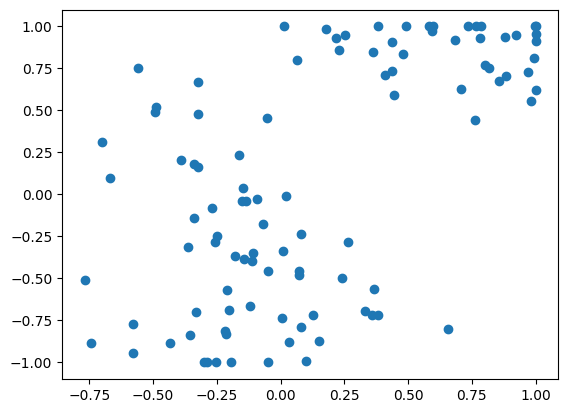

In [ ]:
sample_context_arr = np.array(sample_context_list)
plt.scatter(sample_context_arr[:, 0], sample_context_arr[:, 1])
plt.show()

In [ ]:
arr_data = np.array(ppo_agent.context_buffer)

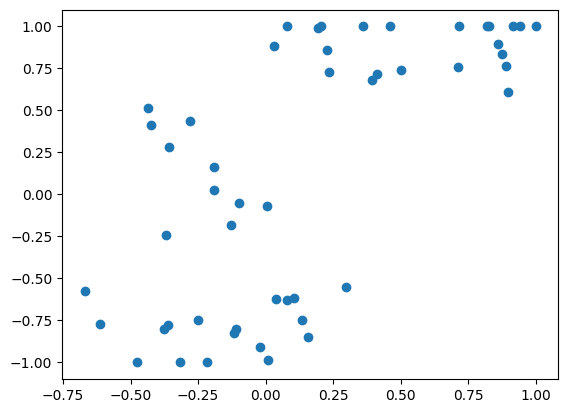

In [ ]:
plt.scatter(arr_data[:,0], arr_data[:, 1])

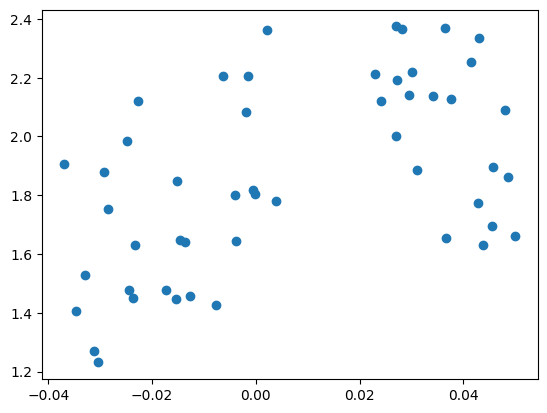

In [ ]:
obs_data = arr_data.sum(axis=1) * 0.025

plt.scatter(obs_data, c_rewards)

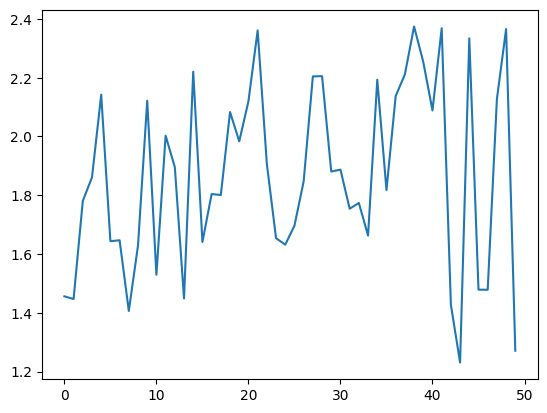

In [ ]:
c_rewards = ppo_agent.context_rewards

plt.plot(c_rewards)

In [ ]:
len(c_rewards)

50